In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [2]:
# use pennylane dataset
h2datasets = qml.data.load('qchem', molname="H2" , basis="STO-3G", bondlength=1.1)
print(h2datasets[0].fci_energy)
print(h2datasets[0].vqe_energy)
print(h2datasets[0].vqe_params)

hamiltonian = h2datasets[0].hamiltonian
print(hamiltonian)

# get the qubits
qubits = len(hamiltonian.wires)
print(qubits)


-1.0791924385860894
-1.0790498801289743
[0.39979198]
  (-0.3796867241618816) [I0]
+ (-0.10485523662149618) [Z2]
+ (-0.10485523662149615) [Z3]
+ (0.1265398827193729) [Z0]
+ (0.1265398827193729) [Z1]
+ (0.10102818539518765) [Z0 Z2]
+ (0.10102818539518765) [Z1 Z3]
+ (0.15183377864956338) [Z0 Z3]
+ (0.15183377864956338) [Z1 Z2]
+ (0.15229282586796247) [Z0 Z1]
+ (0.1593698831813122) [Z2 Z3]
+ (-0.05080559325437572) [Y0 Y1 X2 X3]
+ (-0.05080559325437572) [X0 X1 Y2 Y3]
+ (0.05080559325437572) [Y0 X1 X2 Y3]
+ (0.05080559325437572) [X0 Y1 Y2 X3]
4


In [3]:
from CQS.methods import *
#We will also use:
import numpy as np

from CQS.util.IO import tuplesToMatrix
from CQS.util.verification import *
import openfermion
from openfermion import FermionOperator

In [4]:
def convert_to_cqs(hamiltonian_terms, qubits):
    # Mapping from operator symbols to integers for CQS
    op_map = {'I': 0, 'X': 1, 'Y': 2, 'Z': 3}

    #Lists to hold the coefficients and operator tuples for each term
    coefs = []
    ops = []

    # Process each term in the Hamiltonian
    for term in hamiltonian_terms:
        coef, operators = term.strip().split(' ', 1)
        coef = float(coef.strip('()'))  # Strip parentheses before converting to float

    #Initialize operator tuple for this term with identity operators for all qubits
        op_tuple = [0] * qubits

        # Process each operator in the term
        if operators != '[]':  # Check if there are any operators
            # Remove brackets and split the operators
            op_list = operators[1:-1].split()
            for op in op_list:
                op_type, op_idx = op[0], int(op[1:])  # Extract operator type and index
                op_tuple[op_idx] = op_map[op_type]  # Map the operator to its integer representation

        # Append the coefficient and operator tuple to their respective lists
        coefs.append(coef)
        ops.append(tuple(op_tuple))

    return coefs, ops

str_hamiltonian=str(hamiltonian)

# Step 2: Split the string into individual terms
terms = str_hamiltonian.strip().split('\n+ ')

# Step 3 and 4: Trim whitespace and encapsulate each term in quotes
hamiltonian_terms = [f"{term.strip()}" for term in terms]

print(convert_to_cqs(hamiltonian_terms, qubits))



([-0.3796867241618816, -0.10485523662149618, -0.10485523662149615, 0.1265398827193729, 0.1265398827193729, 0.10102818539518765, 0.10102818539518765, 0.15183377864956338, 0.15183377864956338, 0.15229282586796247, 0.1593698831813122, -0.05080559325437572, -0.05080559325437572, 0.05080559325437572, 0.05080559325437572], [(0, 0, 0, 0), (0, 0, 3, 0), (0, 0, 0, 3), (3, 0, 0, 0), (0, 3, 0, 0), (3, 0, 3, 0), (0, 3, 0, 3), (3, 0, 0, 3), (0, 3, 3, 0), (3, 3, 0, 0), (0, 0, 3, 3), (2, 2, 1, 1), (1, 1, 2, 2), (2, 1, 1, 2), (1, 2, 2, 1)])


In [5]:
#Now, we can put all this together:

#Step 1: Create an Empty Hamiltonian Object
MolH = Hamiltonian(qubits)

#Use Hamiltonian.addTerms to build the Hamiltonian:
MolH.addTerms(convert_to_cqs(hamiltonian_terms, qubits))
#There's an IIII term we would rather not deal with, so we can remove it like this:
MolH.removeTerm((0,0,0,0))
#This gives:
MolH.getHamiltonian(type='printText')

#Be careful choosing an involution, because it might now decompose such that the Hamiltonian is in M:
try:
    MolC = Cartan(MolH, involution='countX')
except Exception as e:
    print('Default Even/Odd Involution does not work:')
    print(e)
#print('countY does work though. g = ')
#MolC = Cartan(MolH, involution='countY')
print(MolC.g)

-0.10485523662149618 * IIZI
-0.10485523662149615 * IIIZ
0.1265398827193729 * ZIII
0.1265398827193729 * IZII
0.10102818539518765 * ZIZI
0.10102818539518765 * IZIZ
0.15183377864956338 * ZIIZ
0.15183377864956338 * IZZI
0.15229282586796247 * ZZII
0.1593698831813122 * IIZZ
-0.05080559325437572 * YYXX
-0.05080559325437572 * XXYY
0.05080559325437572 * YXXY
0.05080559325437572 * XYYX
[(2, 2, 2, 1), (1, 1, 1, 2), (2, 1, 2, 2), (1, 2, 1, 1), (2, 2, 1, 2), (1, 1, 2, 1), (2, 1, 1, 1), (1, 2, 2, 2), (0, 0, 3, 0), (0, 0, 0, 3), (3, 0, 0, 0), (0, 3, 0, 0), (3, 0, 3, 0), (0, 3, 0, 3), (3, 0, 0, 3), (0, 3, 3, 0), (3, 3, 0, 0), (0, 0, 3, 3), (3, 3, 0, 3), (0, 3, 3, 3), (3, 3, 3, 0), (3, 0, 3, 3), (2, 2, 1, 1), (1, 1, 2, 2), (2, 1, 1, 2), (1, 2, 2, 1), (2, 2, 2, 2), (1, 1, 1, 1), (2, 1, 2, 1), (1, 2, 1, 2)]


In [6]:
print(MolC.h)

[(0, 0, 3, 0), (0, 0, 0, 3), (3, 0, 0, 0), (0, 3, 0, 0), (3, 0, 3, 0), (0, 3, 0, 3), (3, 0, 0, 3), (0, 3, 3, 0), (3, 3, 0, 0), (0, 0, 3, 3), (3, 3, 0, 3), (0, 3, 3, 3), (3, 3, 3, 0), (3, 0, 3, 3)]


In [19]:
MolPar = FindParameters(MolC) #Parameters for Cartan decomposition

Optimization terminated successfully.
         Current function value: 0.167763
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
--- 0.24712800979614258 seconds ---
Optimization Error:
7.1764626777600414e-12


In [20]:
print(MolPar.cartan.h)
print(MolPar.hCoefs)

print(MolPar.cartan.k)
print(MolPar.kCoefs)

[(0, 0, 3, 0), (0, 0, 0, 3), (3, 0, 0, 0), (0, 3, 0, 0), (3, 0, 3, 0), (0, 3, 0, 3), (3, 0, 0, 3), (0, 3, 3, 0), (3, 3, 0, 0), (0, 0, 3, 3), (3, 3, 0, 3), (0, 3, 3, 3), (3, 3, 3, 0), (3, 0, 3, 3)]
[(-0.009228691496445366+0j), (0.04157690175438723+0j), (0.030913337591343834+0j), (-0.019892255659488635+0j), 0.10102818539518765, 0.10102818539518765, 0.15183377864956338, 0.15183377864956338, 0.15229282586796247, 0.1593698831813122, (0.0956265451250509+0j), (-0.09562654512802775+0j), (0.14643213837588331+0j), (-0.1464321383788602+0j)]
[(2, 2, 2, 1), (1, 1, 1, 2), (2, 1, 2, 2), (1, 2, 1, 1), (2, 2, 1, 2), (1, 1, 2, 1), (2, 1, 1, 1), (1, 2, 2, 2)]
[ 0.07231713 -0.07231714 -0.07231402  0.07231405  0.26866503 -0.26866503
  0.26866229 -0.26866225]


In [21]:
MolPar.printResult()

Printing Results:
K elements 

0.0723171348021432  *YYYX
-0.0723171363388928 *XXXY
-0.07231401666552803*YXYY
0.07231405178690418 *XYXX
0.26866502879353493 *YYXY
-0.268665027782905  *XXYX
0.2686622891955727  *YXXX
-0.2686622520933785 *XYYY

 h elements: 
 
(-0.009228691496445366+0j)*IIZI
(0.04157690175438723+0j) *IIIZ
(0.030913337591343834+0j)*ZIII
(-0.019892255659488635+0j)*IZII
0.10102818539518765      *ZIZI
0.10102818539518765      *IZIZ
0.15183377864956338      *ZIIZ
0.15183377864956338      *IZZI
0.15229282586796247      *ZZII
0.1593698831813122       *IIZZ
(0.0956265451250509+0j)  *ZZIZ
(-0.09562654512802775+0j)*IZZZ
(0.14643213837588331+0j) *ZZZI
(-0.1464321383788602+0j) *ZIZZ
Normed Error |KHK - Exact|:
1.031174019994022e-05


In [22]:
# test example 
exTime = 500
U_cartan=KHK(MolPar.kCoefs, np.multiply(MolPar.hCoefs,exTime),MolC.k, MolC.h)
U_exact=exactU(MolH.HCoefs,MolH.HTuples,exTime)

trotter_h = convert_to_cqs(hamiltonian_terms, qubits)
trotter_h = list(zip(*trotter_h))

U_trotter = Trotter(trotter_h, exTime, qubits, 3)

In [23]:
print(np.linalg.norm(U_exact - U_cartan))
print(np.linalg.norm(U_exact - U_trotter))

2.6480246889899418e-05
5.026016775049313


We could be tempted to say already that the Cartan decomposition is much more accurate than Trotterisation decomposition. The advantage would be clearer by comparing the two for equal depth. Since Cardan decomposition has a fixed depth and trotterisation depth circuit scales exponentially with the approximation order, we'll stick to the order 1. We want to find the trotter step that allows to match the depth of the Cartan decompisition to ensure that we are compared the two at the same of circuit depth.

We will therefore build the circuit for both the Cartan decomposition and the trotterisation decomposition and compare them to the unitary of the exact solution. For we will use a simple circuit in Pennylane. Basically in this circuit, wa are preparing a Hartree-Fock (HF) state as an approximation to the ground state of a molecular Hamiltonian, I evolve this state using Trotterization, and then I measure the expectation value of the Hamiltonian in the resulting state. We are essentially conducting a simulation of the quantum dynamics of the molecuile in its ground state under the dymanics of the Hamiltonian of the molecule and the result should be the energy of the system at a given time t.

The nature of the circuit itself is not important, the important thing is to compare figure out the depth of circuit of the Cartan decomposition and the Trotterisation decomposition. The time chosen for both the cartan decomposition and the trotterisation decomposition are not relevant for now for the trotter order will be relevant to choose a depth of the trotter circuit that matches the depth of the Cartan decomposition.

In [24]:
def cartan_circuit(kCoefs, hCoefs, k, h):
    """
    Defines the Unitary for the KHK<sup>†</sup>]

    Specifically, performs ℿ<sub>i</sub> e<sup>i•k[l]•kCoefs[l]</sup> ℿ<sub>j</sub> e<sup>i•h[j]•hCoefs[j]</sup>  ℿ<sub>l</sub> e<sup>i•k[(lenK - l)]•kCoefs[(lenK - l)]</sup> 

    Multiply by t before passing the coefficients for h. Do not multiply h by i, that is automatic. The coefficients should be real for k, imaginary for h

    Args:
        kCoefs (List): A list of (real) coefficients for k
        hCoefs (List): The list of (imaginary) coefficients for the elements in h. 
        k (List of Tuples): The list of (PauliStrings)
        h (List of Tuples): List of (PauliStrings) for h (in the same indexing)


    """
    op_map = {0: qml.Identity, 1: qml.PauliX, 2: qml.PauliY, 3: qml.PauliZ}

    for (term, co)  in zip(reversed(k[::-1]), reversed(kCoefs[::-1])):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, -1j*co)

    #H terms
    for (term, co) in zip(reversed(h), reversed(hCoefs)):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, 1j*co)

    #First loop of K terms:
    for (term, co)  in zip(reversed(k), reversed(kCoefs)):
        op = op_map[term[0]](wires=0)
        for i in range(1, len(term)):
            op = op @ op_map[term[i]](wires=i)
        qml.exp(op, 1j*co)

dev = qml.device("lightning.qubit", wires= qubits)

@qml.qnode(dev)
def cartan_depth_circuit(kCoefs, hCoefs, k, h, time):
    cartan_circuit(kCoefs, np.multiply(hCoefs,time), k, h)
    return qml.state()

# the depth of the cartan circuit is the same, we can just check it out at two different times

cartan_depth = qml.specs(cartan_depth_circuit, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,500)['resources'].depth
print(cartan_depth)

cartan_depth_2 = qml.specs(cartan_depth_circuit, expansion_strategy="device")(MolPar.kCoefs, MolPar.hCoefs,MolC.k, MolC.h,1000)['resources'].depth
print(cartan_depth_2)


56
56


In [13]:
# let's check the depth of the trotter circuit in term of number of trotter steps
# we use order 1 for the trotterization

def trotter_circuit(ham, time, steps):
    """
    Prepares U_t, the Trotterized input U

    Args:
        ham (List of Tuples): Hamiltonian formatted as (co, (PauliString))
        time (float): final time to evolve to
        N (int): number of qubits
        steps (int): Number of trotter steps to take
    
    Returns:
        The U<sub>trotter</sub>(t) that approximates U<sub>exact</sub>(t)
    """
    timeStep = time/steps
    op_map = {0: qml.Identity, 1: qml.PauliX, 2: qml.PauliY, 3: qml.PauliZ}
    for i in range(steps):
        for (co, pauliTuple) in ham[::-1]:
            op = op_map[pauliTuple[0]](wires=0)
            for i in range(1, len(pauliTuple)):
                op = op @ op_map[pauliTuple[i]](wires=i)
            qml.exp(op, 1j*co*timeStep)

dev = qml.device("lightning.qubit", wires= qubits)
@qml.qnode(dev)
def trotter_depth_circuit(ham, time, steps):
    trotter_circuit(ham, time, steps)
    return qml.expval(hamiltonian)

# ex :
trotter_depth = qml.specs(trotter_depth_circuit, expansion_strategy="device")(trotter_h, 500, 3)['resources'].depth
print(trotter_depth)



48


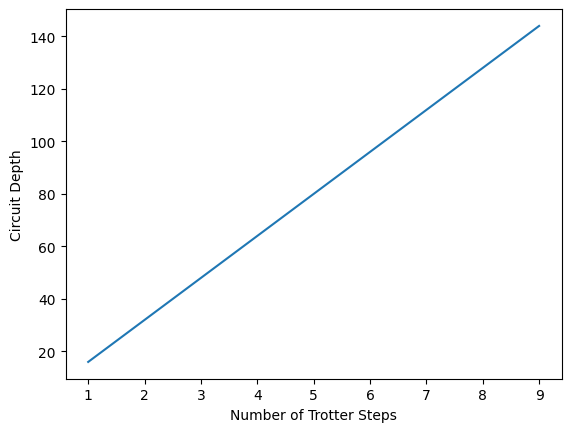

[16, 32, 48, 64, 80, 96, 112, 128, 144]


In [25]:
trotter_depths = [qml.specs(trotter_depth_circuit, expansion_strategy="device")(trotter_h, 500, i)['resources'].depth for i in range(1, 10)]
plt.plot(range(1, 10), trotter_depths)
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Circuit Depth')
plt.show()
print(trotter_depths)

When comparing this function, it's similar to the qml.ApproxTimeEvolution function to compare with. I will stick with Pennylane for now since it's implemented. We can also use the previous function but for some reason they don't give the same depth.

In [26]:
# run trotterized evolution
dev = qml.device("lightning.qubit", wires= qubits)

@qml.qnode(dev)
def pennylane_trotter_depth_circuit(time, trotter_steps):
    qml.ApproxTimeEvolution(hamiltonian, time =time , n=trotter_steps)
    return qml.state()

# ex
dep = qml.specs(pennylane_trotter_depth_circuit, expansion_strategy="device")(500, 3)['resources'].depth
print(dep)

55


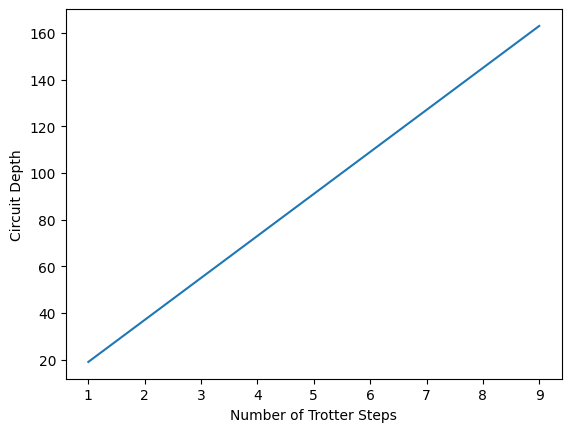

[19, 37, 55, 73, 91, 109, 127, 145, 163]


In [27]:
pennylane_trotter_depths = [qml.specs(pennylane_trotter_depth_circuit, expansion_strategy="device")(500, i)['resources'].depth for i in range(1, 10)]
plt.plot(range(1, 10), pennylane_trotter_depths)
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Circuit Depth')
plt.show()
print(pennylane_trotter_depths)


We can see that the depth of the Cartan decomposition circuit is 56 and the depth of the Trotter circuit for number of trotter steps of 3 is 55. This is a good basis for comparison.
We will not plot the exact error in terms of the time for the Cartan decomposition and the Trotter decomposition.

In [28]:
# test example 
time = np.linspace(0, 1000, 100)
trotter_steps = 3

cartan_error = np.zeros_like(time)
trotter_error = np.zeros_like(time)

for i in range(len(time)):
    U_cartan=KHK(MolPar.kCoefs, np.multiply(MolPar.hCoefs,time[i]),MolC.k, MolC.h)
    U_exact=exactU(MolH.HCoefs,MolH.HTuples,time[i])
    U_trotter = Trotter(trotter_h, time[i], qubits, 3)
   
    cartan_error[i] = np.linalg.norm(U_exact - U_cartan)
    trotter_error[i] = np.linalg.norm(U_exact - U_trotter)

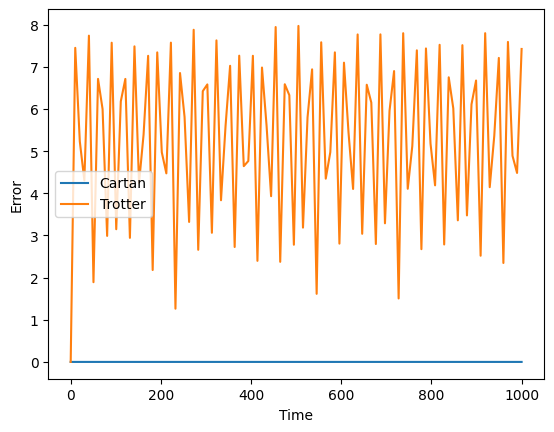

In [29]:
plt.plot(time, cartan_error, label='Cartan')
plt.plot(time, trotter_error, label='Trotter')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

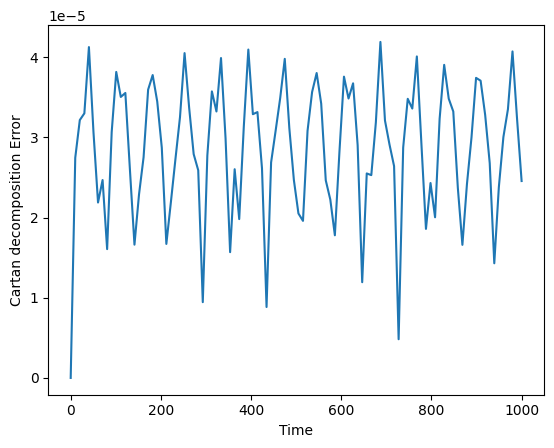

In [30]:
plt.plot(time, cartan_error)
plt.xlabel('Time')
plt.ylabel('Cartan decomposition Error')
plt.show()

# Quantum Phase Estimation to have the energy of the system at a given time t.

In [65]:
aux = 4
dev = qml.device("lightning.qubit", wires= qubits + aux)

wires_target = range(qubits)
wires_estimation = range(qubits, qubits + aux)

hf = h2datasets[0].hf_state


In [66]:
# get the quantum phase estimation circuit using the exact exp(iUt) operator
@qml.qnode(dev)
def exact_QPE(HCoefs, HTuples, time): 
    qml.BasisState(hf, wires=wires_target)
    U_exact=exactU(HCoefs,HTuples,time)
    qml.QuantumPhaseEstimation(U_exact, target_wires=wires_target, estimation_wires=wires_estimation)
    return qml.probs(wires_estimation)

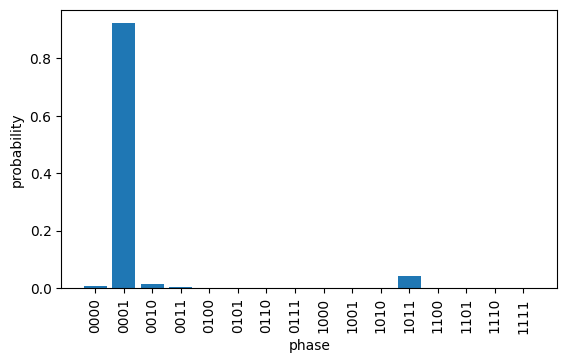

Energy estimated:  0.0625


In [67]:
# ex run
exact_probs = exact_QPE(MolH.HCoefs,MolH.HTuples,700)
bit_strings = [f"{x:0{len(wires_estimation)}b}" for x in range(len(exact_probs))]
plt.bar(bit_strings, exact_probs)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.show()

# get the estimated energy
phase_estimated = np.argmax(exact_probs) / 2 ** len(wires_estimation)
print("Energy estimated: ", phase_estimated)

In [68]:
# egt the estimated energy array in terms of the time
time = np.linspace(0, 1000, 100)
target_energies = np.zeros_like(time)

for i in range(len(time)):
    exact_probs = exact_QPE(MolH.HCoefs,MolH.HTuples,time[i])
    phase_estimated = np.argmax(exact_probs) / 2 ** len(wires_estimation)
    target_energies[i] = phase_estimated

In [70]:
# get the quantum phase estimation circuit using the cartan decomposition to obtain the exp(iUt) operator
@qml.qnode(dev)
def cartan_QPE(kCoefs, hCoefs, k, h, time): 
    qml.BasisState(hf, wires=wires_target)
    U_cartan = KHK(kCoefs, np.multiply(hCoefs,time),k, h)
    qml.QuantumPhaseEstimation(U_cartan, target_wires=wires_target, estimation_wires=wires_estimation)
    return qml.probs(wires_estimation)

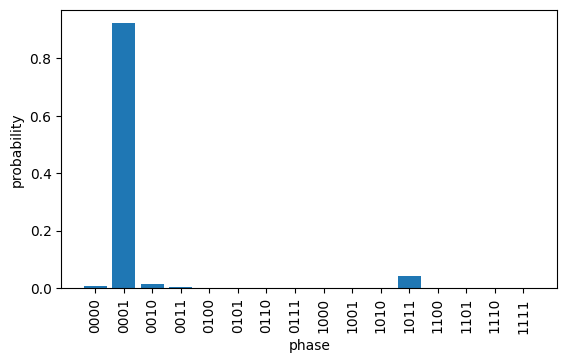

Energy estimated:  0.0625


In [71]:
# ex run
cartan_probs = cartan_QPE(MolPar.kCoefs, MolPar.hCoefs, MolC.k, MolC.h,700 )
bit_strings = [f"{x:0{len(wires_estimation)}b}" for x in range(len(cartan_probs))]
plt.bar(bit_strings, cartan_probs)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.show()

# get the estimated energy
phase_estimated = np.argmax(cartan_probs) / 2 ** len(wires_estimation)
print("Energy estimated: ", phase_estimated)

In [72]:
# get the estimated energy array in terms of the time
time = np.linspace(0, 1000, 100)
cartan_energies = np.zeros_like(time)

for i in range(len(time)):
    cartan_probs = cartan_QPE(MolPar.kCoefs, MolPar.hCoefs, MolC.k, MolC.h,time[i] )
    phase_estimated = np.argmax(cartan_probs) / 2 ** len(wires_estimation)
    cartan_energies[i] = phase_estimated

In [73]:
# get the quantum phase estimation circuit using trotter decomposition to obtain the exp(iUt) operator
@qml.qnode(dev)
def trotter_QPE(ham, time, steps):
    qml.BasisState(hf, wires=wires_target)
    U_trotter = Trotter(ham, time, qubits, steps)
    qml.QuantumPhaseEstimation(U_trotter, target_wires=wires_target, estimation_wires=wires_estimation)
    return qml.probs(wires_estimation)

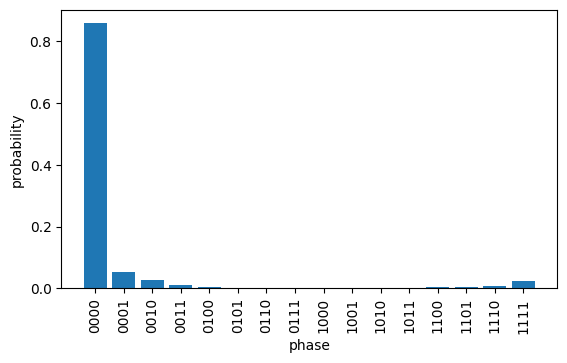

Energy estimated:  0.0


In [74]:
# ex run
trotter_probs = trotter_QPE(trotter_h,700, 3)
bit_strings = [f"{x:0{len(wires_estimation)}b}" for x in range(len(trotter_probs))]
plt.bar(bit_strings, trotter_probs)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.show()

# get the estimated energy
phase_estimated = np.argmax(trotter_probs) / 2 ** len(wires_estimation)
print("Energy estimated: ", phase_estimated)

In [75]:
# get the estimated energy array in terms of the time
time = np.linspace(0, 1000, 100)
trotter_energies = np.zeros_like(time)

for i in range(len(time)):
    trotter_probs = trotter_QPE(trotter_h,time[i], 3)
    phase_estimated = np.argmax(trotter_probs) / 2 ** len(wires_estimation)
    trotter_energies[i] = phase_estimated

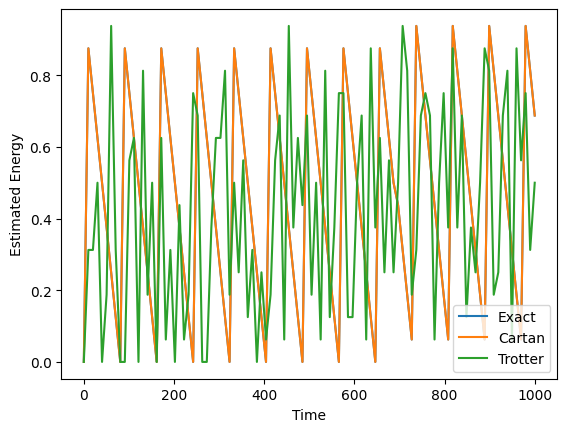

In [77]:
plt.plot(time, target_energies, label='Exact')
plt.plot(time, cartan_energies, label='Cartan')
plt.plot(time, trotter_energies, label='Trotter')
plt.xlabel('Time')
plt.ylabel('Estimated Energy')
plt.legend()